In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import FeatureExtract as F
from multiprocessing import Process, Pool
from random import sample
from tqdm import tqdm
from Dataset import Dataset
from utils import unpackSIFTOctave, draw_pyramid_distribution, splitFeatureByScale
from pyDBow3 import Vocabulary
from pyp.ObjectDetection import Draw
method = "SIFT"
npoints = 2000
matcher = F.getmatcher(method)
# load vocabulary 
voc = Vocabulary()
voc.readFromFile("SIFT_visdrone_4_20000.voc".format(method))
node2word = voc.wordIdd2NodeId()
print(voc)

nwords: 10000
depths: 4
descriptor size 128 
K: 10 
weight method: TF_IDF
score method: L2_NORM



In [3]:
dataset = Dataset("../data")
imgleft, _ , imgwide = dataset.get_random_image() 
# Draw.pltshow([imgleft, imgwide])
imgleftgray, imgwidegray = cv2.cvtColor(imgleft, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgwide, cv2.COLOR_BGR2GRAY)
fl, dl = F.extract(imgleftgray, npoints,3,  method)
fw, dw = F.extract(imgwidegray, npoints,3,  method)
featuresl = splitFeatureByScale(fl, dl)
featuresw = splitFeatureByScale(fw, dw)
featuresl.keys(), featuresw.keys()

(dict_keys([2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125]),
 dict_keys([2.0, 1.0, 0.5, 0.25, 0.125]))

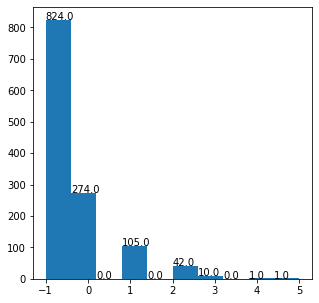

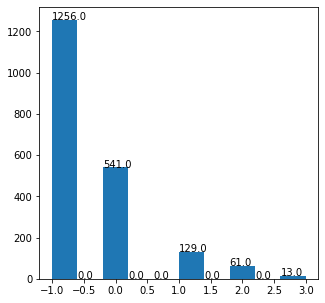

In [4]:
draw_pyramid_distribution(fl)
draw_pyramid_distribution(fw)

In [5]:
# load and transform 

def calVectorp(feature_level):
    bv, fv = voc.transform(feature_level, 0)

    # create P 
    p = np.zeros(voc.getWordSize())
    for nodeid, fid in fv.items():
        wid = int(node2word[nodeid])
        weight = bv[wid] 
        # weight = 1 * len(fid)
        # word = voc.getWord(wid)
        p[wid] = 1
        # print(wid, weight)
        # p[wid] = 100123
    # p[9999] = 1000
    return p
def calMatrixP(feature):
    P = []
    all_scale = []
    for scale, feature_info in feature.items():
        cnt_feature = len(feature_info["feature"])
        vp = calVectorp(feature_info["descriptor"])
        # vp = vp / cnt_feature
        vp = vp / np.sum(vp)
        P.append(vp / cnt_feature)
        all_scale.append(scale)
    return np.array(P),all_scale

(7, 10000) (5, 10000)


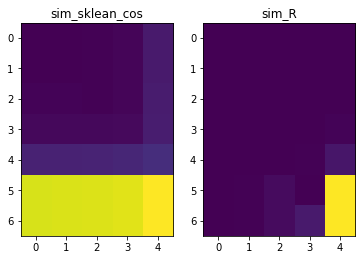

In [6]:
matl, labell= calMatrixP(featuresl)
matw, labelw= calMatrixP(featuresw)
print(matl.shape, matw.shape)
from sklearn import metrics
sim_AB= metrics.pairwise.cosine_similarity(matl,matw) 
sim_AB= metrics.pairwise.manhattan_distances (matl,matw) 
R = matl @ (matw.transpose())
# plt.imshow(sim_AB)
ax = plt.subplot(1,2,1)
ax.set_title("sim_sklean_cos")
ax.imshow(sim_AB)
ax= plt.subplot(1,2,2)
ax.set_title("sim_R")
ax.imshow(R)
plt.show()

In [7]:
# matl matw 里面的最大值
np.max(matl), np.max(matw)

(1.0, 0.00641025641025641)

[2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125] [2.0, 1.0, 0.5, 0.25, 0.125]
7


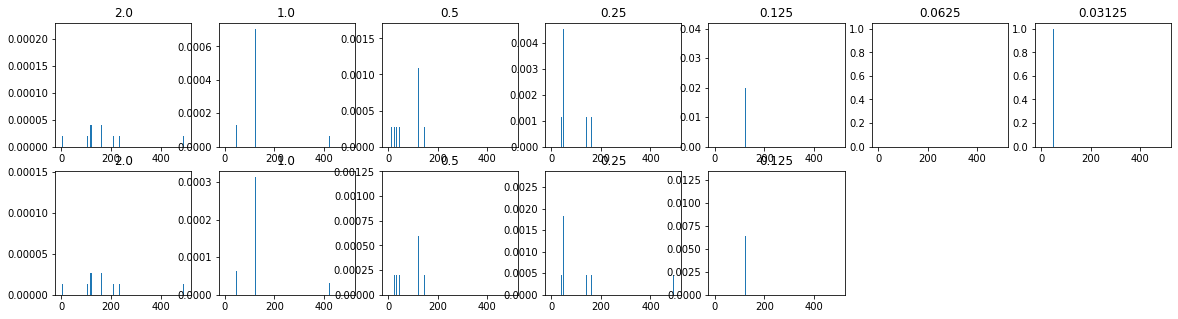

In [8]:
def draw_hist(matl,labell, matw, labelw):
    plt.figure(figsize=(20,5))
    plt.tight_layout()
    col = max(matl.shape[0], matw.shape[0])
    print(col)
    ax = plt.gca()
    scale_factor = 20
    def _draw(mat, label, offset = 0):
        for i in range(mat.shape[0]):
            # f = mat[i] / np.sum(mat[i])
            f = mat[i] 
            scalesd_f = np.zeros(f.shape[0] // scale_factor)
            for j in range(mat[i].shape[0]):
                scalesd_f[j // scale_factor] += mat[i][j]
            ax = plt.subplot(2, col, col * offset + i + 1)
            ax.bar(range(0, scalesd_f.shape[0]), scalesd_f)
            ax.set_title("{}".format(label[i]))
    _draw(matl, labell, 0)
    _draw(matw, labelw, 1)
    plt.show()        
print(labell, labelw)
draw_hist(matl,labell, matw, labelw)

1 1


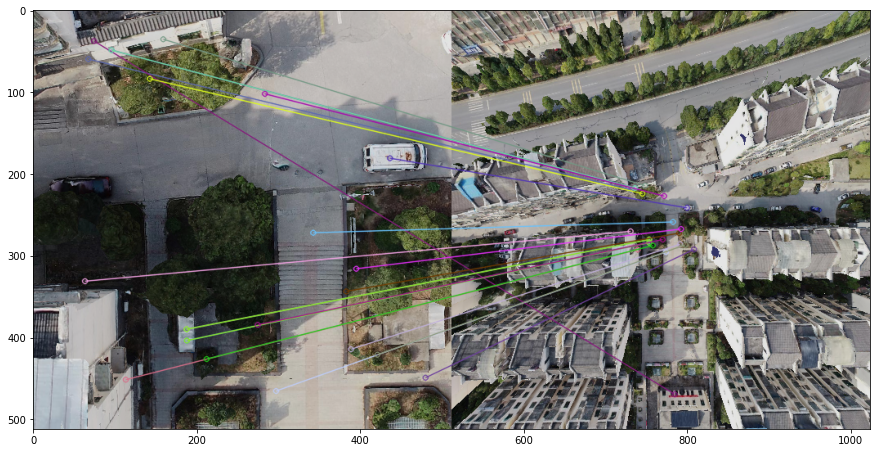

0.25 1.0


In [9]:
# 计算真是的匹配
match_res = F.match(dl, dw, matcher)
left = []
wide = []
for match in match_res:
    i , j  = match.queryIdx, match.trainIdx
    kpi = unpackSIFTOctave(fl[i])[-1]
    kpj = unpackSIFTOctave(fw[j])[-1]
    left.append(kpi)
    wide.append(kpj)
# 计算众数
from collections import Counter
left_factor = max(Counter(left), key=Counter(left).get)
wide_factor = max(Counter(wide), key=Counter(wide).get)

outimg = cv2.drawMatches(imgleft, fl, imgwide, fw, match_res,None, [-1,-1,-1], [-1,-1,-1] , None, cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
Draw.pltshow(outimg)
print(left_factor, wide_factor)

(512, 512, 3) (512, 512, 3)
2 2


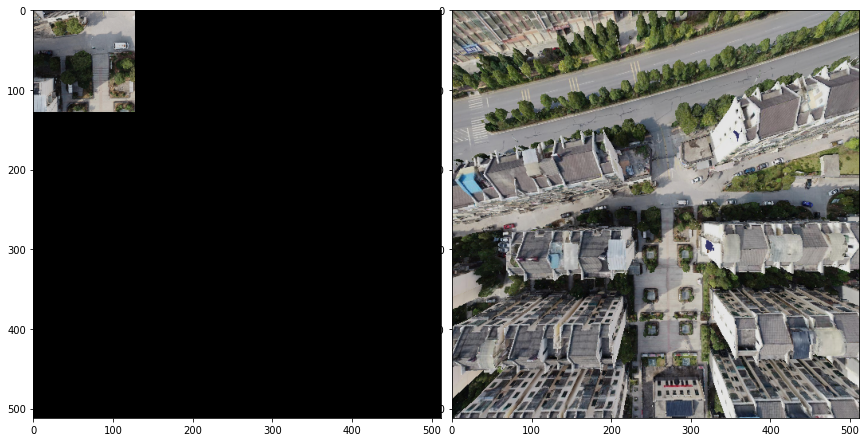

In [10]:
# resize image 
def rescale(img, sacle_factor):
    if (sacle_factor > 1): return img
    newsize = list(map(int, np.array(img.shape[:2]) * sacle_factor))
    outimg = np.zeros_like(img)
    outimg[:newsize[0], :newsize[1]] = cv2.resize(img, tuple(map(int,newsize)))
    return outimg

img_resizedl = rescale(imgleft, left_factor)
img_resizedw = rescale(imgwide, wide_factor)
print(img_resizedl.shape, img_resizedw.shape)
Draw.pltshow([img_resizedl, img_resizedw])